# Principal Component Analysis
'''
Created on Tue 03 Mar 2020'''
Based on Mon 10 Feb 2020 version of pca analysis.

This notebook is intended to run the principal component analysis on the covariance matrix of the neural activity.
Some parts of the notebook are similar to the correlation analysis because trial concatenation and re-arrangement of the data to run multiple analysis.  
## Importation of libraries and definition of specific data to use

In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import matplotlib.cm as cm
import figures as figs
from sklearn.decomposition import PCA
import scipy

Define mouse to analize as well as preprocessing analysis versions

mouse -> mouse identity //
decoding_v  -> decoding version //
motion_correction_v - > motion correction version. 100 is aligned one. //
alignment_v -> alignment version//
equalization_v -> equalization version//
source_extraction_v -> source extraction version//
component_evaluation_v -> component evaluation version//
registration_v -> registration version//

sf = 10 -> signal sampling frequency //
re_sf= 20 -> resample integer (will take one every re_sf point ans use the mean)

In [34]:
mouse = 56166           ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 100 ### 100 means everything was aligned, 200 means it was also equalized
alignment_v = 1           ## alignment version
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version
registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 20                 ## value of resampling

session_now = 2 
fixed = 'None'
## define task for plotting. This will cahnge for other mice!!!!
if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        if mouse == 32364:
            fixed = 'LR'
        if mouse == 56165:
            fixed = 'UR'
    else:
        if session_now == 2:
            task = 'STABLE'
        else:
            task = 'RANDOM'
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'
            
if mouse == 32366:
    sessions = [3,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'

Define all necesary directories from calcium activity, behavioural data, objects position and timeline

In [35]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_normed/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/scoring_time_vector/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figures_path = os.environ['PROJECT_DIR'] +'neural_analysis/data/process/figures/pca/'

## Principal Components over the entire session

We will run PCA over the traces of a complete session and plot the principal projections over the first components.

In [36]:
# define all relevant files names
session = session_now
file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_1_v' + f'{decoding_v}' + '.4.' + f'{100}' + \
                      '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                      f'{component_evaluation_v}' + '.' + f'{registration_v}' + '.npy'
time_file_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_1_v' + f'{decoding_v}' + '.4.' + f'{1}' + \
                      '.' + f'{0}' + '.pkl'
beh_file_name= 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_event_' + f'{re_sf}' + '.npy'

In [37]:
##load activity and timeline
activity = np.load(file_directory + file_name_session_1)
timeline_file = open(timeline_file_dir + time_file_session_1, 'rb')
timeline_info = pickle.load(timeline_file)
##normalize neural activity
timeline = np.zeros(len(timeline_info) + 1)
for i in range(len(timeline_info)):
    timeline[i] = timeline_info[i][1]
timeline[len(timeline_info)] = activity.shape[1]
neural_activity1 = activity[1:,:]
##downsample neural activity
resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity1,
                                                                                    re_sf=re_sf)


In this instance we run PCA manually using the compute covariance funcion, eigenvelues and igenvectors using numpy and compute projection by rotation of the data. 

In [38]:
## run pca analysis on covariance matrix
n_components = 6
cov_matrix = stats.cov_matrix(neural_activity = neural_activity1) ## compute covariance matrix
eigenvalues, eigenvectors = stats.compute_PCA(corr_matrix = cov_matrix) ## run eigenvalues and eigenvectors analysis
projection = stats.PCA_projection(neural_activity=neural_activity1, eigenvalues=eigenvalues,
                            eigenvectors=eigenvectors, n_components=n_components) ## project to n_componets

Verify explained variance (EV) and eigenvalues espectrum as well and visualize some eigenvector's componentes.

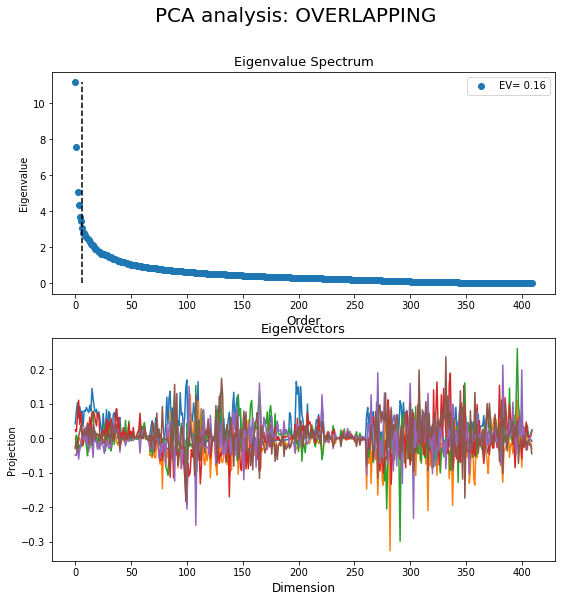

In [39]:
## define path to save eigendecomposition and plot
pca_fig_path =  figures_path + 'pca_eigendecomposition_mouse_'+f'{mouse}' +'_session_'+f'{session}_binsize_'+f'{re_sf}'+'.png'
figs.plot_pca_decomposition(eigenvalues = eigenvalues, eigenvectors = eigenvectors, n_components = n_components,\
                            title = task , path_save = pca_fig_path)

Plot projections on the first components to see time evolution over the different components. we will take n_componets and plot them in groups of three, but always having the first component as fixed. 

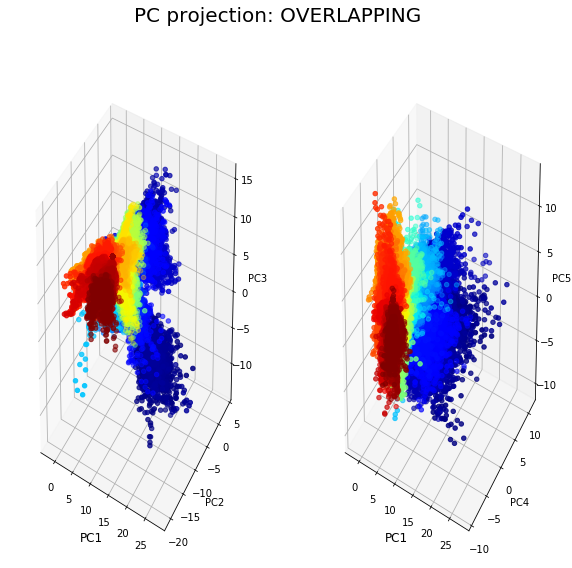

In [40]:
## define path for figura of projections and plot
pca_fig_path =  figures_path + 'pca_mouse_'+f'{mouse}' +'_session_'+f'{session}_binsize_'+f'{re_sf}'+'.png'
figs.plot_pca_projection(projection = projection, title = task, path_save = pca_fig_path)

## PCA and behavioural representations

Here the question is whether the represetnation changes when the animal is doing different activities: resting period, non exploring objects periods and object exploration periods (differenciated by object positions LL,LR,UR and UR).

Two different analysis can be done. First as previously done, using the projections that are computed over the entire data or second looking for differences in the principal eigenvectors when doing PCA only in the different behavioural segments.


In [41]:
## load behavioural file, downsample it and separate different parts of the experiment
behaviour = np.load(behaviour_dir + beh_file_name)
# resample neural activity and behavioural vector
reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
resample_beh = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])
resample_timeline = timeline/re_sf
color = np.linspace(0, 20, len(resample_beh))

In [42]:
## separate different behavioural parts of the experiment (in neural activity and in projected activity as well)

# define a variable with only training data (remove testing)
training_data = resample_neural_activity_mean[:, :int(resample_timeline[40])] ## neural activity in training
training_data_beh = resample_beh[:int(resample_timeline[40])]        ## bahavioural vector in training
testing_data = resample_neural_activity_mean[:,int(resample_timeline[40]):]  ## neural activity in testing
testing_data_beh= resample_beh[int(resample_timeline[40]):]   ## behavior in testing

projection_data = projection[:n_components, :int(resample_timeline[40])]
projection_data_testing = projection[:n_components, int(resample_timeline[40]):]

neural_activity_training = [] ## list containing neural activity for different bahavioural parts
neural_activity_testing = []  ## list containing different behaviours in the testing trial

projection_training = []    ## list of projected activity in pca during training
projection_testing = []     ## list of projected activity in pca during testing

color_training=[]           ## arrange of colors. Will be necesary to have a common color criteria when plotting

for condition in range(6):     ## 6 different behaviours defined here
    neural_activity_training.append(training_data[:,np.where(training_data_beh== condition)])
    neural_activity_testing.append(testing_data[:,np.where(testing_data_beh== condition)])
    projection_training.append(projection_data[:,np.where(training_data_beh== condition)])
    projection_testing.append(projection_data_testing[:,np.where(training_data_beh== condition)])
    color_training.append(color[np.where(training_data_beh==condition)])

### Analysis on projections related to behaviour

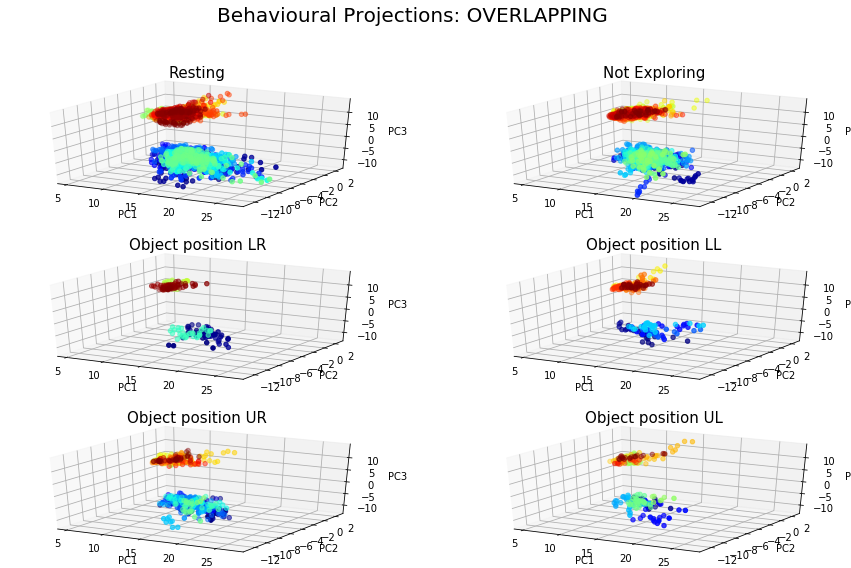

In [43]:
## define path to save figures and plot
pca_behavioral_path = figures_path + 'pca_behaviour_training_mouse_'+f'{mouse}' +'_session_'+f'{session}_binsize_'+f'{re_sf}'+'.png'
figs.plot_pca_behavioral_representation(components_list = projection_training, color = color_training, title = task,
                                        path_save = pca_behavioral_path)

#pca_behavioral_path_test = figures_path + 'pca_behaviour_testing_mouse_'+f'{mouse}' +'_session_'+f'{session}_binsize_'+f'{re_sf}'+'.png'
#figs.plot_pca_behavioral_representation(components_list = projection_training, color = color_training, title = task,
#                                        path_save = pca_behavioral_path)


### Analysis on eigenvectors for different behaviours

Here we will run PCA on the data corresponding to different behavioural conditions and evaluate whether the principal eigenvectors are significantly different from each other. For doing that we will take into account the complete set of principal components to analyze, not only comparing eigenvectore #1 of one condition to #1 of the other, but the hole set. We will compute the distance between this vectores and compare the distribution of distances. 

In [44]:
## create an eigenvalues and eigenvectors list that will contain the PCA analysis for every behavioural condition
eigenvectors_list = []
eigenvalues_list = []
for i in range(len(neural_activity_training)):
    cov_matrix = stats.cov_matrix(neural_activity=neural_activity_training[i][:,0,:])  ## compute covariance matrix
    eigVal, eigVec = stats.compute_PCA(corr_matrix=cov_matrix)  ## run eigenvalues and eigenvectors analysis
    eigenvectors_list.append(eigVec)
    eigenvalues_list.append(eigVal)

For the PCA analysis is necessary to check the eigenvalues spectrum(as well as explained variance). We will plot the eigenvalues spectrum for the different behavioural conditions, and the distributions o the distance between all the eigenvectors (or something like that...lets think about this) 

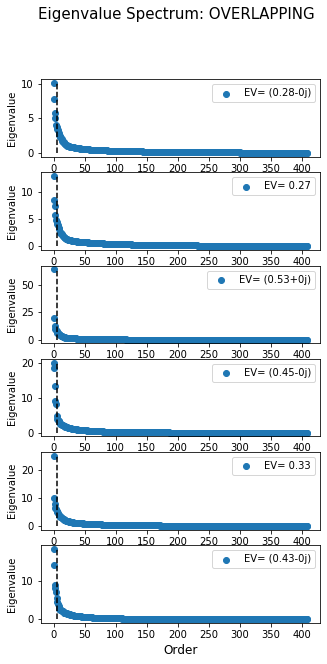

In [45]:
## plot multiple spectrum of different conditions
pca_spectrum_behaviour_path =  figures_path + 'pca_spectrum_behaviour_mouse_'+f'{mouse}' +'_session_'+f'{session}_binsize_'+f'{re_sf}'+'.png'
figs.plot_pca_spectrum_behaviour(eigenvalues = eigenvalues_list, n_components = n_components , title = task, path_save = pca_spectrum_behaviour_path)

Using the explained variance as a measure of dimensionality we check the neural representation dimension for different behavioural condionts. For the we use different values of desired explained variance and check the number of components that are required to reach that explained variance in multiple conditions. 

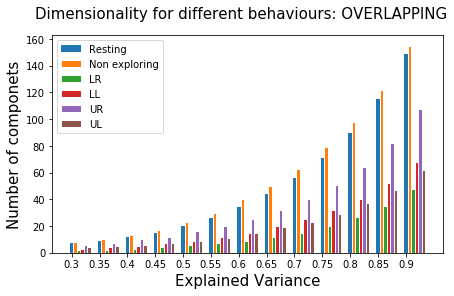

In [46]:
## plot dimension using EV
pca_EV_behaviour =  figures_path + 'pca_EV_behaviour_mouse_'+f'{mouse}' +'_session_'+f'{session}_binsize_'+f'{re_sf}'+'.png'
desired_ev = [0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.70,0.75,0.8,0.85,0.9]
figs.plot_pca_EV_behaviour_dimension(eigenvalues = eigenvalues_list, ev = desired_ev, task = task, path_save = pca_EV_behaviour)


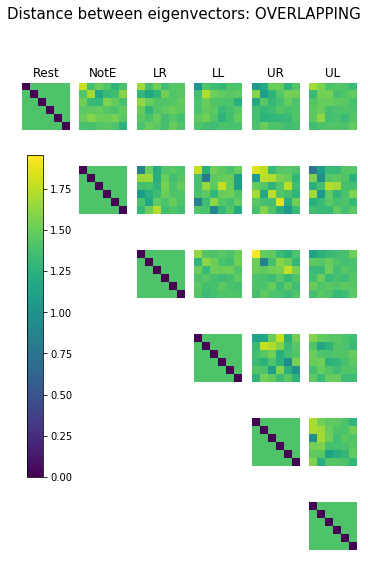

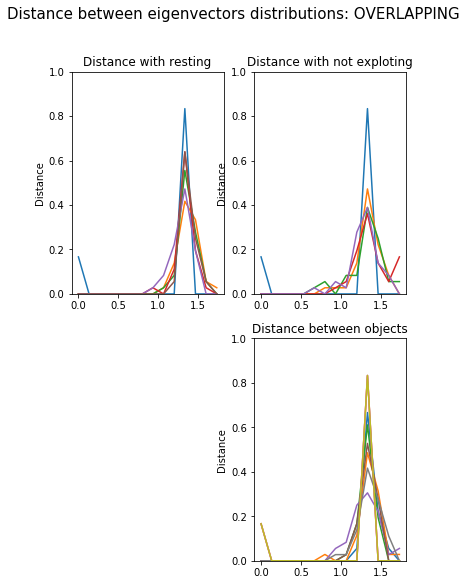

In [47]:
## plot distance betweenn n_components eigenvectors in the different behavioural conditions
pca_eigenvector_distance_path =  figures_path + 'pca_eigenvector_distance_behaviour_mouse_'+f'{mouse}' +'_session_'\
                +f'{session}_binsize_'+f'{re_sf}'+'.png'
figs.plot_pca_eigenvector_distance_behaviour(eigenvectors=eigenvectors_list, n_components=n_components,
                                             title=task, path_save=pca_eigenvector_distance_path)

## plot distribution of distance values
pca_eigenvector_distance_dist_path =  figures_path + 'pca_eigenvector_distance_dist_behaviour_mouse_'+f'{mouse}'\
                +'_session_'+f'{session}_binsize_'+f'{re_sf}'+'.png'
figs.plot_pca_eigenvector_distance_distribution_behaviour(eigenvectors=eigenvectors_list, n_components=n_components,
                                                          title=task, path_save=pca_eigenvector_distance_dist_path)


## PCA and training over days (learning?)

In [48]:
## separate neural activity in corresponding days (differenciating trials and resting periods)
## this part is just manipulating positions in the array and rearange them

neural_activity_days = [] ## list that will contain neural activity in trials separated in days
projection_days = []      ## list that will contain projection over n_componets in separated days
time_length = np.diff(resample_timeline)

for i in range(4):
    day_matrix = np.zeros((resample_neural_activity_mean.shape[0],int(np.sum(time_length[i*10:(i+1)*10:2]))))
    projection_matrix = np.zeros((n_components,int(np.sum(time_length[i*10:(i+1)*10:2]))))
    start_time = 0
    for j in range(0,10,2):
        trial = i*10 + j
        day_matrix[:,start_time:start_time+ int(time_length[trial])] = \
            resample_neural_activity_mean[:,int(resample_timeline[trial]):int(resample_timeline[trial]) + int(time_length[trial])]
        projection_matrix[:,start_time:start_time+ int(time_length[trial])] =\
        projection[:,int(resample_timeline[trial]):int(resample_timeline[trial]) + int(time_length[trial])]
        start_time = start_time + int(time_length[trial])
    neural_activity_days.append(day_matrix)
    projection_days.append(projection_matrix)

neural_activity_resting_days = []    ## list that will contain neural activity in resting periods separated in days
projection_resting_days = []         ## list that will contain projection over n_componets in resting periods
time_length = np.diff(resample_timeline)
for i in range(4):
    day_matrix = np.zeros((resample_neural_activity_mean.shape[0],int(np.sum(time_length[i*10+1:(i+1)*10+1:2]))))
    projection_matrix = np.zeros((n_components,int(np.sum(time_length[i*10+1:(i+1)*10+1:2]))))
    start_time = 0
    for j in range(1,10,2):
        trial = i*10 + j
        day_matrix[:,start_time:start_time+ int(time_length[trial])] = \
            resample_neural_activity_mean[:,int(resample_timeline[trial]):int(resample_timeline[trial]) + int(time_length[trial])]
        projection_matrix[:,start_time:start_time+ int(time_length[trial])] =\
        projection[:,int(resample_timeline[trial]):int(resample_timeline[trial]) + int(time_length[trial])]
        start_time = start_time + int(time_length[trial])
    neural_activity_resting_days.append(day_matrix)
    projection_resting_days.append(projection_matrix)

neural_activity_resting_days.append(resample_neural_activity_mean[:,int(resample_timeline[-2]):int(resample_timeline[-1])])
neural_activity_days.append(resample_neural_activity_mean[:,int(resample_timeline[-3]):int(resample_timeline[-2])])
projection_days.append(projection[:,int(resample_timeline[-2]):int(resample_timeline[-1])])
projection_resting_days.append(projection[:,int(resample_timeline[-3]):int(resample_timeline[-2])])


With the neural activity that is separated by days, run pca multiple times

In [49]:
## create a list of eigenvectors and eigenvalues that contains PCA analysis over the days

eigenvectors_list = []
eigenvalues_list = []
for i in range(len(neural_activity_resting_days)):
    cov_matrix = stats.cov_matrix(neural_activity=neural_activity_days[i])  ## compute covariance matrix
    eigVal, eigVec = stats.compute_PCA(corr_matrix=cov_matrix)  ## run eigenvalues and eigenvectors analysis
    eigenvectors_list.append(eigVec)
    eigenvalues_list.append(eigVal)
for i in range(len(neural_activity_days)):
    cov_matrix = stats.cov_matrix(neural_activity=neural_activity_resting_days[i])  ## compute covariance matrix
    eigVal, eigVec = stats.compute_PCA(corr_matrix=cov_matrix)  ## run eigenvalues and eigenvectors analysis
    eigenvectors_list.append(eigVec)
    eigenvalues_list.append(eigVal)


Generate different plotting anaysis: eigenvalues spectrum for multiple days/resting conditions, ...

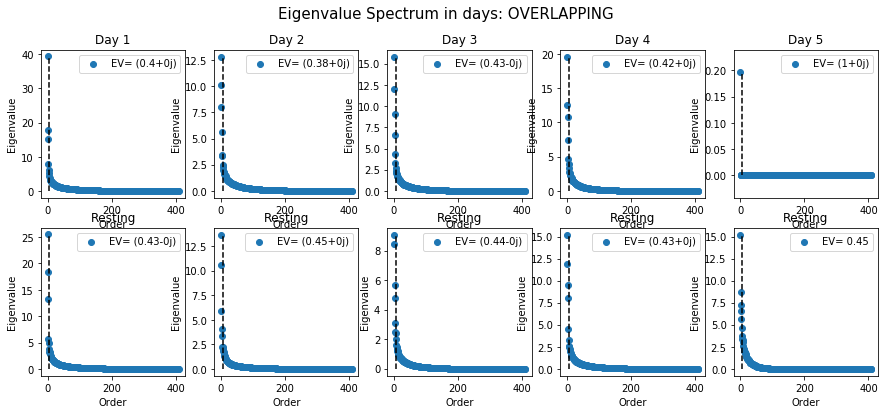

In [50]:
## define 
pca_learning_days_spectrum_path =  figures_path + 'pca_eigenvalue_spectrum_learning_mouse_'+f'{mouse}'\
                +'_session_'+f'{session}_binsize_'+f'{re_sf}'+'.png'
figs.plot_eigenvalues_spectrum_learning(eigenvalues = eigenvalues_list, n_components = n_components ,
                                        title = task, path_save = pca_learning_days_spectrum_path)

Now, lets check whether the dimensionality of the neural representation changes over the days.

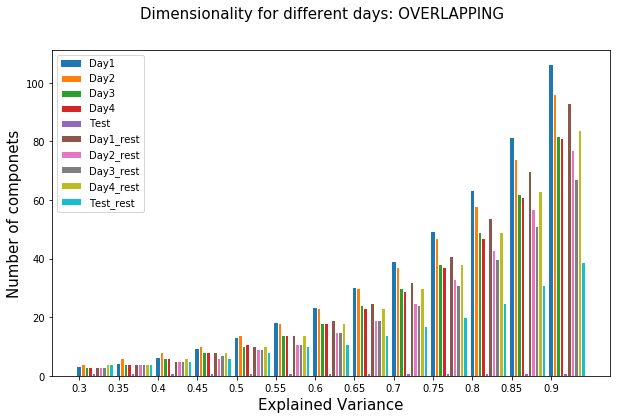

In [51]:
### plot dimension using EV
pca_EV_learning_days_path =  figures_path + 'pca_EV_learning_mouse_'+f'{mouse}'\
                +'_session_'+f'{session}_binsize_'+f'{re_sf}'+'.png'
desired_ev = [0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9]
figs.plot_pca_EV_dimension_learning(eigenvalues = eigenvalues_list, ev = desired_ev , task = task, path_save = pca_EV_learning_days_path)

## PCA and trials.

Doing a comparison for all trials is more demanding, so in this case we will analyze the evolution of the explained variance over multiple trials when we take into account n number of componets, and will vary the number of components. If the dimension of the system were somehow changing the number of components to explain the same variance should change, OR, variance explained using the same number of components should change as well. 

So, we separate each trial, and run PCA over data from each trial. Importan: Take into account that each trial has around 3000 frames. If resampling frequency is 20, that is lowed down to 150...

In [52]:
## Separate neural activity in trials
neural_activity_days = []
time_length = np.diff(resample_timeline)
for i in range(0,42,2):
    trial_matrix = resample_neural_activity_mean[:,int(resample_timeline[i]):int(resample_timeline[i]) + int(time_length[i])]
    neural_activity_days.append(trial_matrix)

neural_activity_resting_days = []
for i in range(1,42,2):
    trial_matrix = resample_neural_activity_mean[:,int(resample_timeline[i]):int(resample_timeline[i]) + int(time_length[i])]
    neural_activity_resting_days.append(trial_matrix)

In [53]:
## Compute eigenvectors and eigenvalues for different trials in trian and resting conditions

eigenvectors_list_trials = []
eigenvalues_list_trials = []
for i in range(len(neural_activity_days)):
    cov_matrix = stats.cov_matrix(neural_activity=neural_activity_days[i])  ## compute covariance matrix
    eigVal, eigVec = stats.compute_PCA(corr_matrix=cov_matrix)  ## run eigenvalues and eigenvectors analysis
    eigenvectors_list_trials.append(eigVec)
    eigenvalues_list_trials.append(eigVal)

eigenvectors_list_resting = []
eigenvalues_list_resting = []
for i in range(len(neural_activity_resting_days)):
    cov_matrix = stats.cov_matrix(neural_activity=neural_activity_resting_days[i])  ## compute covariance matrix
    eigVal, eigVec = stats.compute_PCA(corr_matrix=cov_matrix)  ## run eigenvalues and eigenvectors analysis
    eigenvectors_list_resting.append(eigVec)
    eigenvalues_list_resting.append(eigVal)


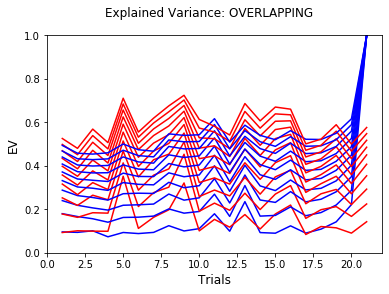

In [54]:
## Plot explained variance for multiple n componets selected over the multiple trials, separating trials and
## resting periods

pca_EV_learning_path =  figures_path + 'pca_explained_variance_learning_mouse_'+f'{mouse}'\
                +'_session_'+f'{session}_binsize_'+f'{re_sf}'+'.png'
figs.plot_pca_EV_learning(eigenvalues1= eigenvalues_list_trials, eigenvalues2 = eigenvalues_list_resting,
                          n_components = n_components, title = task, path_save = pca_EV_learning_path)



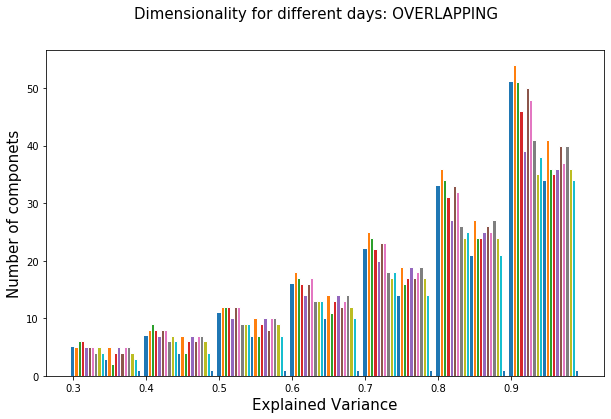

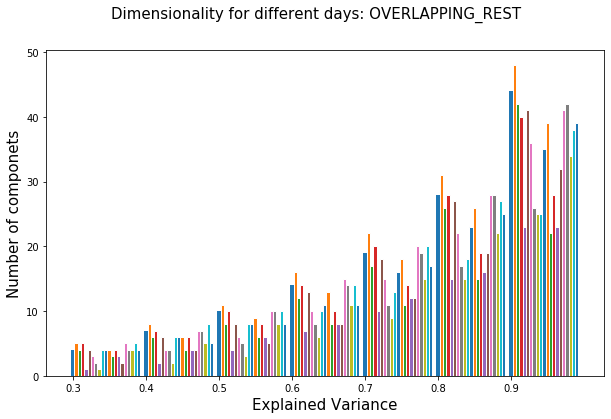

In [55]:
pca_EV_dim_learning_path_trials =  figures_path + 'pca_dimension_learning_trials_mouse_'+f'{mouse}'\
                +'_session_'+f'{session}_binsize_'+f'{re_sf}'+'.png'
desired_ev = [0.3,0.4,0.5,0.6,0.7,0.8,0.9]
figs.plot_pca_EV_dimension_learning_trials(eigenvalues = eigenvalues_list_trials, ev = desired_ev , task = task, path_save = pca_EV_dim_learning_path_trials)
pca_EV_dim_learning_path_rest =  figures_path + 'pca_dimension_learning_rest_mouse_'+f'{mouse}'\
                +'_session_'+f'{session}_binsize_'+f'{re_sf}'+'.png'
figs.plot_pca_EV_dimension_learning_trials(eigenvalues = eigenvalues_list_resting, ev = desired_ev , task = task + '_REST', path_save = pca_EV_dim_learning_path_rest)